# EfficientNet's diagnostic performance

This notebook contains the code to compute the F1, precision, recall and specificity scores for model predictions test set. It is assumed that the predictions have already been made and that they are available in a .csv/pickle file

In [1]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, recall_score, precision_score, confusion_matrix, accuracy_score

In [2]:
# Set paths
base_model_pred_path = Path('./efficientnet-final-size')
model_pred_fn = [Path('efficientnetb4_' + str(i) + '_preds.csv') for i in range(5)]
model_pred_fn

[PosixPath('efficientnetb4_0_preds.csv'),
 PosixPath('efficientnetb4_1_preds.csv'),
 PosixPath('efficientnetb4_2_preds.csv'),
 PosixPath('efficientnetb4_3_preds.csv'),
 PosixPath('efficientnetb4_4_preds.csv')]

In [3]:
dfs = [pd.read_pickle(base_model_pred_path / model_pred_fn[i]) for i in range(5)]

In [4]:
dfs[0]

,actual,pred,filenames
0,0,0,Acne/032439HB.jpeg
1,0,0,Acne/032462HB.jpeg
2,0,0,Acne/032653HB.jpeg
3,0,2,Acne/032720HB.jpeg
4,0,0,Acne/032879HB.jpeg
...,...,...,...
561,5,4,Vitiligo/vitiligo-66--WatermarkedWyJXYXRlcm1hc...
562,5,2,Vitiligo/vitiligo1--WatermarkedWyJXYXRlcm1hcmt...
563,5,4,Vitiligo/vitiligo2--WatermarkedWyJXYXRlcm1hcmt...
564,5,2,Vitiligo/vitiligo3--WatermarkedWyJXYXRlcm1hcmt...


In [5]:
# Filter so that only 525 included
include_images = pd.read_csv('./include_images_525.csv')
include_images.head()

,Unnamed: 0,image_id
0,0,005103HB.json
1,1,016003HB.json
2,2,016013HB.json
3,3,016139HB.json
4,4,016263HB.json


In [6]:
for i in range(len(dfs)):
    dfs[i] = dfs[i].loc[[True if filename in include_images.image_id.apply(lambda x: x.split('.')[0]).values else False for filename in dfs[i].filenames.apply(lambda x: x.split('/')[1].split('.')[0]).values ]]

dfs[0]

,actual,pred,filenames
0,0,0,Acne/032439HB.jpeg
1,0,0,Acne/032462HB.jpeg
2,0,0,Acne/032653HB.jpeg
3,0,2,Acne/032720HB.jpeg
4,0,0,Acne/032879HB.jpeg
...,...,...,...
561,5,4,Vitiligo/vitiligo-66--WatermarkedWyJXYXRlcm1hc...
562,5,2,Vitiligo/vitiligo1--WatermarkedWyJXYXRlcm1hcmt...
563,5,4,Vitiligo/vitiligo2--WatermarkedWyJXYXRlcm1hcmt...
564,5,2,Vitiligo/vitiligo3--WatermarkedWyJXYXRlcm1hcmt...


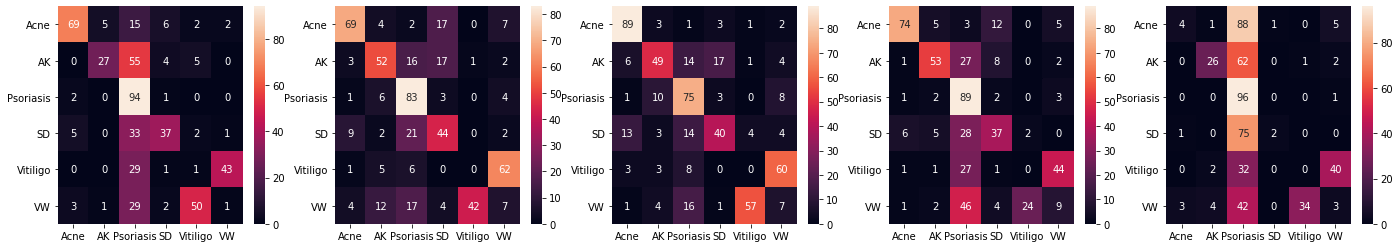

In [7]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['Acne',
               'AK',
               'Psoriasis',
               'SD',
               'Vitiligo',
               'VW'
              ]

fig, axs = plt.subplots(1, 5, figsize=(24, 4))
for i in range(5):
    cm = confusion_matrix(dfs[i]['actual'].values, dfs[i]['pred'].values)

    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    sn.heatmap(df_cm, annot=True, ax=axs[i])
plt.show()
fig.savefig('efficientnet_cm.png')

In [8]:
# Compute the precision, recall and f1-score for each class. The specificity and NPV scores are not a part of the
# "classification_report" function and will be computed separately in a cell below.
per_model_res = []
class_names = ['acne',
               'actinic_keratosis',
               'psoriasis_no_pustular',
               'seborrheic_dermatitis',
               'vitiligo',
               'wart'
              ]

for i in range(5):
    per_model_res.append(
        classification_report(
            dfs[i].actual, 
            dfs[i].pred,
            labels=[0, 1, 2, 3, 4, 5],
            target_names=class_names,
        output_dict=True
        )#['macro avg']
    )

In [9]:
per_model_res[0]

{'acne': {'precision': 0.8734177215189873,
  'recall': 0.696969696969697,
  'f1-score': 0.7752808988764046,
  'support': 99},
 'actinic_keratosis': {'precision': 0.8181818181818182,
  'recall': 0.2967032967032967,
  'f1-score': 0.435483870967742,
  'support': 91},
 'psoriasis_no_pustular': {'precision': 0.3686274509803922,
  'recall': 0.9690721649484536,
  'f1-score': 0.5340909090909091,
  'support': 97},
 'seborrheic_dermatitis': {'precision': 0.7254901960784313,
  'recall': 0.47435897435897434,
  'f1-score': 0.5736434108527132,
  'support': 78},
 'vitiligo': {'precision': 0.016666666666666666,
  'recall': 0.013513513513513514,
  'f1-score': 0.014925373134328358,
  'support': 74},
 'wart': {'precision': 0.02127659574468085,
  'recall': 0.011627906976744186,
  'f1-score': 0.015037593984962407,
  'support': 86},
 'accuracy': 0.4361904761904762,
 'macro avg': {'precision': 0.47061007486182943,
  'recall': 0.41037425891178,
  'f1-score': 0.39141034281784326,
  'support': 525},
 'weighted 

In [10]:
# Calculate the specificity values.
for i in range(5):  # For each model
    for j in range(6):  # For each class
        cur_class = class_names[j]
        y_true = np.asarray(list(dfs[i].actual)) == j
        y_pred = np.asarray(list(dfs[i].pred)) == j
    
        # By setting the pos_label to 0, we get the specificity instead of the recall.
        per_model_res[i][cur_class]['specificity'] = recall_score(y_true, y_pred, pos_label=0)
        
        # By setting the pos_label to 0, we get the specificity instead of the recall.
        per_model_res[i][cur_class]['NPV'] = precision_score(y_true, y_pred, pos_label=0)
        
        per_model_res[i][cur_class]['accuracy'] = accuracy_score(dfs[i].actual,dfs[i].pred)

In [11]:
per_model_res[0]

{'acne': {'precision': 0.8734177215189873,
  'recall': 0.696969696969697,
  'f1-score': 0.7752808988764046,
  'support': 99,
  'specificity': 0.9765258215962441,
  'NPV': 0.9327354260089686,
  'accuracy': 0.4361904761904762},
 'actinic_keratosis': {'precision': 0.8181818181818182,
  'recall': 0.2967032967032967,
  'f1-score': 0.435483870967742,
  'support': 91,
  'specificity': 0.9861751152073732,
  'NPV': 0.8699186991869918,
  'accuracy': 0.4361904761904762},
 'psoriasis_no_pustular': {'precision': 0.3686274509803922,
  'recall': 0.9690721649484536,
  'f1-score': 0.5340909090909091,
  'support': 97,
  'specificity': 0.6238317757009346,
  'NPV': 0.9888888888888889,
  'accuracy': 0.4361904761904762},
 'seborrheic_dermatitis': {'precision': 0.7254901960784313,
  'recall': 0.47435897435897434,
  'f1-score': 0.5736434108527132,
  'support': 78,
  'specificity': 0.9686800894854586,
  'NPV': 0.9135021097046413,
  'accuracy': 0.4361904761904762},
 'vitiligo': {'precision': 0.01666666666666666

# Print confusion matrics 

The classes are:  
acne,  
actinic_keratosis,  
psoriasis_no_pustular,  
seborrheic_dermatitis,  
vitiligo,  
wart  


In [12]:
confusion_matrix(dfs[0].actual, dfs[0].pred)

array([[69,  5, 15,  6,  2,  2],
       [ 0, 27, 55,  4,  5,  0],
       [ 2,  0, 94,  1,  0,  0],
       [ 5,  0, 33, 37,  2,  1],
       [ 0,  0, 29,  1,  1, 43],
       [ 3,  1, 29,  2, 50,  1]])

In [13]:
confusion_matrix(dfs[1].actual, dfs[1].pred)

array([[69,  4,  2, 17,  0,  7],
       [ 3, 52, 16, 17,  1,  2],
       [ 1,  6, 83,  3,  0,  4],
       [ 9,  2, 21, 44,  0,  2],
       [ 1,  5,  6,  0,  0, 62],
       [ 4, 12, 17,  4, 42,  7]])

In [14]:
confusion_matrix(dfs[2].actual, dfs[2].pred)

array([[89,  3,  1,  3,  1,  2],
       [ 6, 49, 14, 17,  1,  4],
       [ 1, 10, 75,  3,  0,  8],
       [13,  3, 14, 40,  4,  4],
       [ 3,  3,  8,  0,  0, 60],
       [ 1,  4, 16,  1, 57,  7]])

In [15]:
confusion_matrix(dfs[3].actual, dfs[3].pred)

array([[74,  5,  3, 12,  0,  5],
       [ 1, 53, 27,  8,  0,  2],
       [ 1,  2, 89,  2,  0,  3],
       [ 6,  5, 28, 37,  2,  0],
       [ 1,  1, 27,  1,  0, 44],
       [ 1,  2, 46,  4, 24,  9]])

In [16]:
confusion_matrix(dfs[4].actual, dfs[4].pred)

array([[ 4,  1, 88,  1,  0,  5],
       [ 0, 26, 62,  0,  1,  2],
       [ 0,  0, 96,  0,  0,  1],
       [ 1,  0, 75,  2,  0,  0],
       [ 0,  2, 32,  0,  0, 40],
       [ 3,  4, 42,  0, 34,  3]])

# Compute the Macro-avg and std for each class across the 5 models

In [17]:
# Create (nested) dict where each of the scores (across the models) for each metric are put into a numpy array.
metrics = ['f1-score', 'precision', 'recall', 'specificity', 'NPV', 'accuracy']
class_scores = {c: {m:np.zeros(5) for m in metrics} for c in class_names}
for i in range(5):
    for c in class_names:
        for m in metrics:
            class_scores[c][m][i] = per_model_res[i][c][m]

In [18]:
# Calculate the mean (micro-avg) and std for each class and each metric.
avg_std_res = {c: {m:() for m in metrics} for c in class_names}
for c in class_names:
    for m in metrics:
        avg_std_res[c][m] = (np.mean(class_scores[c][m]), np.std(class_scores[c][m]))

In [19]:
for c in class_names:
    print(c)
    for m in metrics:
        print(m, avg_std_res[c][m])
    print('\n')

acne
f1-score (0.6480697097591801, 0.28850604600192725)
precision (0.7670168340432514, 0.1390719690001345)
recall (0.6161616161616161, 0.2972512923143871)
specificity (0.9690140845070422, 0.01642521660519804)
NPV (0.9199057340930488, 0.054236763325144266)
accuracy (0.43314285714285716, 0.09453914952891629)


actinic_keratosis
f1-score (0.5454767065999628, 0.09929941255327487)
precision (0.7416006469928039, 0.06795253337051602)
recall (0.45494505494505494, 0.13451554943384048)
specificity (0.9631336405529953, 0.020608921451610963)
NPV (0.89482016474803, 0.02138646326083047)
accuracy (0.43314285714285716, 0.09453914952891629)


psoriasis_no_pustular
f1-score (0.5676932174006672, 0.10624129407920477)
precision (0.4349124346625679, 0.12949660603172927)
recall (0.9010309278350516, 0.07894511224361503)
specificity (0.6700934579439253, 0.20753346026576133)
NPV (0.9725418701216476, 0.017487723395949565)
accuracy (0.43314285714285716, 0.09453914952891629)


seborrheic_dermatitis
f1-score (0.449

# Get Model Performance

In [20]:
for m in range(5):
    model_name = model_pred_fn[m].stem.rpartition('_')[0]
    df_results = pd.DataFrame.from_dict(per_model_res[m], orient = 'columns')
    acc = df_results.loc['precision','accuracy']
    df_results = df_results.loc[['f1-score','recall','specificity'] , ['acne','actinic_keratosis', 'psoriasis_no_pustular','seborrheic_dermatitis', 'vitiligo', 'wart']].T
    df_results['accuracy'] = acc
    df_results.loc['mean'] = df_results.mean()
    print('./' + model_name + '_performance.pkl')
    display(df_results)
    df_results.to_pickle('./' + model_name + '_performance.pkl')

./efficientnetb4_0_performance.pkl


,f1-score,recall,specificity,accuracy
acne,0.775281,0.696970,0.976526,0.43619
actinic_keratosis,0.435484,0.296703,0.986175,0.43619
psoriasis_no_pustular,0.534091,0.969072,0.623832,0.43619
seborrheic_dermatitis,0.573643,0.474359,0.968680,0.43619
vitiligo,0.014925,0.013514,0.869180,0.43619
wart,0.015038,0.011628,0.895216,0.43619
mean,0.391410,0.410374,0.886601,0.43619


./efficientnetb4_1_performance.pkl


,f1-score,recall,specificity,accuracy
acne,0.741935,0.696970,0.957746,0.485714
actinic_keratosis,0.604651,0.571429,0.933180,0.485714
psoriasis_no_pustular,0.685950,0.855670,0.855140,0.485714
seborrheic_dermatitis,0.539877,0.564103,0.908277,0.485714
vitiligo,0.000000,0.000000,0.904656,0.485714
wart,0.082353,0.081395,0.824601,0.485714
mean,0.442461,0.461594,0.897267,0.485714


./efficientnetb4_2_performance.pkl


,f1-score,recall,specificity,accuracy
acne,0.839623,0.898990,0.943662,0.495238
actinic_keratosis,0.601227,0.538462,0.947005,0.495238
psoriasis_no_pustular,0.666667,0.773196,0.876168,0.495238
seborrheic_dermatitis,0.563380,0.512821,0.946309,0.495238
vitiligo,0.000000,0.000000,0.860310,0.495238
wart,0.081871,0.081395,0.822323,0.495238
mean,0.458795,0.467477,0.899296,0.495238


./efficientnetb4_3_performance.pkl


,f1-score,recall,specificity,accuracy
acne,0.808743,0.747475,0.976526,0.499048
actinic_keratosis,0.666667,0.582418,0.965438,0.499048
psoriasis_no_pustular,0.561514,0.917526,0.693925,0.499048
seborrheic_dermatitis,0.521127,0.474359,0.939597,0.499048
vitiligo,0.000000,0.000000,0.942350,0.499048
wart,0.120805,0.104651,0.876993,0.499048
mean,0.446476,0.471071,0.899138,0.499048


./efficientnetb4_4_performance.pkl


,f1-score,recall,specificity,accuracy
acne,0.074766,0.040404,0.990610,0.249524
actinic_keratosis,0.419355,0.285714,0.983871,0.249524
psoriasis_no_pustular,0.390244,0.989691,0.301402,0.249524
seborrheic_dermatitis,0.049383,0.025641,0.997763,0.249524
vitiligo,0.000000,0.000000,0.922395,0.249524
wart,0.043796,0.034884,0.890661,0.249524
mean,0.162924,0.229389,0.847784,0.249524
